In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
import numpy as np
from sklearn.cluster import KMeans

In [3]:
import warnings
warnings.filterwarnings('ignore')

# ***3.1 Explore the data***

## **3.1.1 Load data from my own google driver**
You can visit the code, output and the original data from:https://drive.google.com/drive/folders/18vlAyyRiEKBq9TJ0_HrASgO9WoXN_NJo?usp=sharing

The basic information of the dataset shown as follow 

In [4]:
# Read the dataset
data = pd.read_csv('F:/UZH/semester2/spatial_analysis2/assignment1/dc-isc-lu-data.csv')
print('check the colum the dataset has',data.columns)

check the colum the dataset has Index(['id', 'parcel_name', 'label', 'tw_0', 'tw_1', 'tw_2', 'tw_3', 'tw_4',
       'tw_5', 'tw_6',
       ...
       'entropy_158', 'entropy_159', 'entropy_160', 'entropy_161',
       'entropy_162', 'entropy_163', 'entropy_164', 'entropy_165',
       'entropy_166', 'entropy_167'],
      dtype='object', length=507)


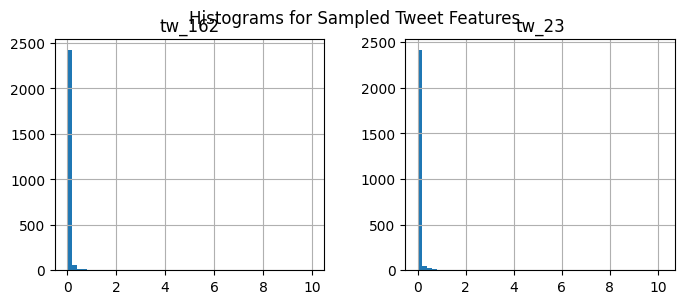

            tw_162        tw_23
count  2520.000000  2520.000000
mean      0.038171     0.047166
std       0.240861     0.300451
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       0.000000     0.000000
max      10.000000    10.190476


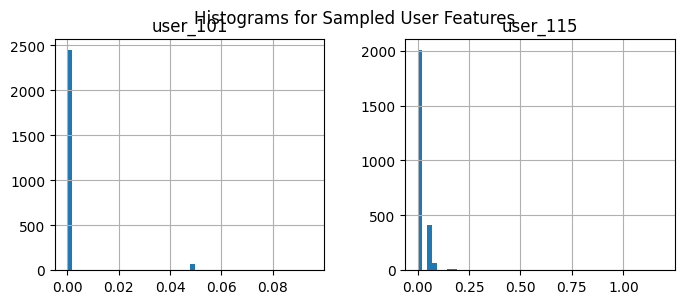

          user_101     user_115
count  2520.000000  2520.000000
mean      0.001455     0.014683
std       0.008520     0.047793
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       0.000000     0.000000
max       0.095238     1.190476


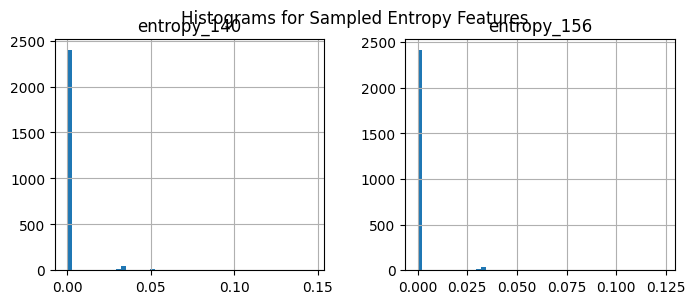

       entropy_140  entropy_156
count  2520.000000  2520.000000
mean      0.001934     0.001737
std       0.009831     0.009362
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       0.000000     0.000000
max       0.146563     0.123265


In [5]:
# Define a function to summarize and plot a group of features
def summarize_plot_features(feature_group, group_name):
    # Sample 4 features from the group for plotting
    sampled_features = feature_group.sample(2, axis=1)
    # Summarize the features
    summary = sampled_features.describe()
    # Plot histograms for the sampled features
    sampled_features.hist(bins=50, figsize=(8, 3))
    plt.suptitle(f'Histograms for Sampled {group_name} Features')
    plt.show()
    return summary

# Group features by type
tweet_features = data.filter(regex='^tw_')
user_features = data.filter(regex='^user_')
entropy_features = data.filter(regex='^entropy_')

# Summarize and plot tweet features
tweet_summary = summarize_plot_features(tweet_features, 'Tweet')
print(tweet_summary)
# Summarize and plot user features
user_summary = summarize_plot_features(user_features, 'User')
print(user_summary)
# Summarize and plot entropy features
entropy_summary = summarize_plot_features(entropy_features, 'Entropy')
print(entropy_summary)

## **3.1.2 Residential and Non-Residential comparision**

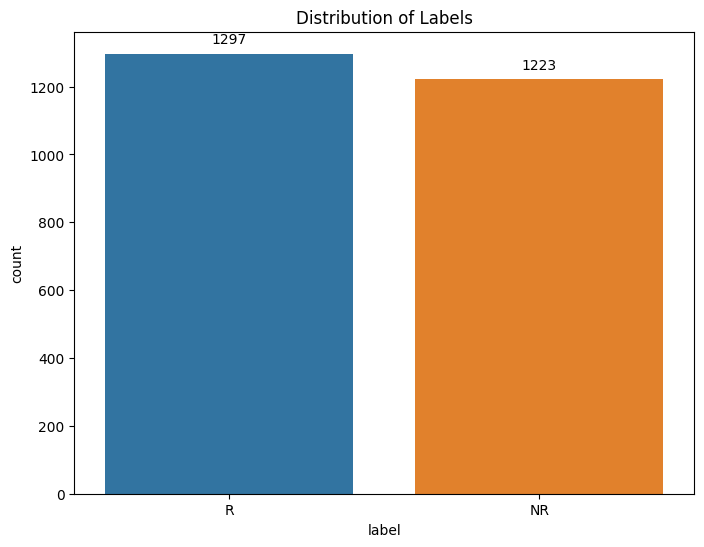

In [6]:
# Assume 'data' is your DataFrame and it has been loaded properly
# Create the countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=data)
plt.title('Distribution of Labels')

# Annotate the number of observations on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

The bar chart illustrates the distribution of labels between Residential (R) and Non-Residential (NR) areas. There are 1,297 instances labeled as Residential and 1,223 as Non-Residential, which indicates a relatively balanced distribution between the two types of land use.

### 3.1.2.1 Hourly data exploration

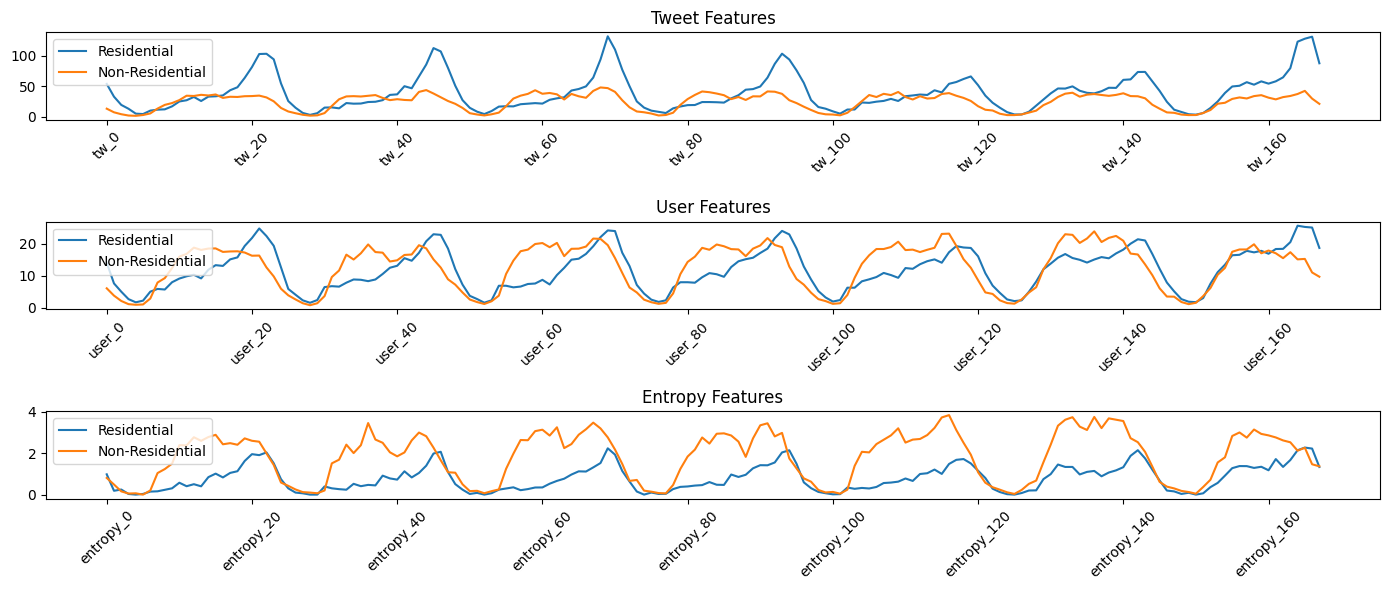

In [7]:
# First, separate the features into categories based on their prefixes
tweet_features = data.filter(regex='^tw_')
user_features = data.filter(regex='^user_')
entropy_features = data.filter(regex='^entropy_')
labels = data['label']

# Group by the label to calculate the sum for R and NR areas
sum_tweets_R = tweet_features[labels == 'R'].sum()
sum_tweets_NR = tweet_features[labels == 'NR'].sum()
sum_users_R = user_features[labels == 'R'].sum()
sum_users_NR = user_features[labels == 'NR'].sum()
sum_entropy_R = entropy_features[labels == 'R'].sum()
sum_entropy_NR = entropy_features[labels == 'NR'].sum()

# Now create line plots for each category
plt.figure(figsize=(14, 6))
plt.subplot(3, 1, 1)
plt.plot(sum_tweets_R.index, sum_tweets_R.values, label='Residential')
plt.plot(sum_tweets_NR.index, sum_tweets_NR.values, label='Non-Residential')
plt.title('Tweet Features')
plt.legend()
plt.xticks(ticks=range(0, len(tweet_features.columns), 20), 
           labels=tweet_features.columns[::20], 
           rotation=45)

plt.subplot(3, 1, 2)
plt.plot(sum_users_R.index, sum_users_R.values, label='Residential')
plt.plot(sum_users_NR.index, sum_users_NR.values, label='Non-Residential')
plt.title('User Features')
plt.legend()
plt.xticks(ticks=range(0, len(user_features.columns), 20), 
           labels=user_features.columns[::20], 
           rotation=45)

plt.subplot(3, 1, 3)
plt.plot(sum_entropy_R.index, sum_entropy_R.values, label='Residential')
plt.plot(sum_entropy_NR.index, sum_entropy_NR.values, label='Non-Residential')
plt.title('Entropy Features')
plt.legend()
plt.xticks(ticks=range(0, len(entropy_features.columns), 20), 
           labels=entropy_features.columns[::20], 
           rotation=45)
plt.tight_layout()
plt.show()


- **Residential (R) Areas**:
    - Peak tweet volume around 8-9 PM, indicating highest activity during these hours.
    -Corresponding peaks in user count and entropy suggest diverse interactions during this time.
- **Non-Residential (NR) Areas**:
    - Lower overall tweet volume compared to R, lacking sharp peaks.
    - Consistently higher user count during daytime hours, suggesting sustained activity in these areas.
    - User count peaks for NR precede those for R, and entropy values are consistently higher throughout the day.  

***Insights:***
1. The pronounced evening peak in R areas might reflect residential downtime.
1. The sustained daytime user activity in NR areas could indicate commercial or business use.
1. The consistently higher entropy in NR areas could reflect a broader variety of topics or more diverse user interactions.-
1. The time-stamped patterns can be indicative of lifestyle and activity differences between residential and non-residential areas.

### 3.1.2.2 Daily data exploration   
Group every 24h (columns) of each feature type and sum them

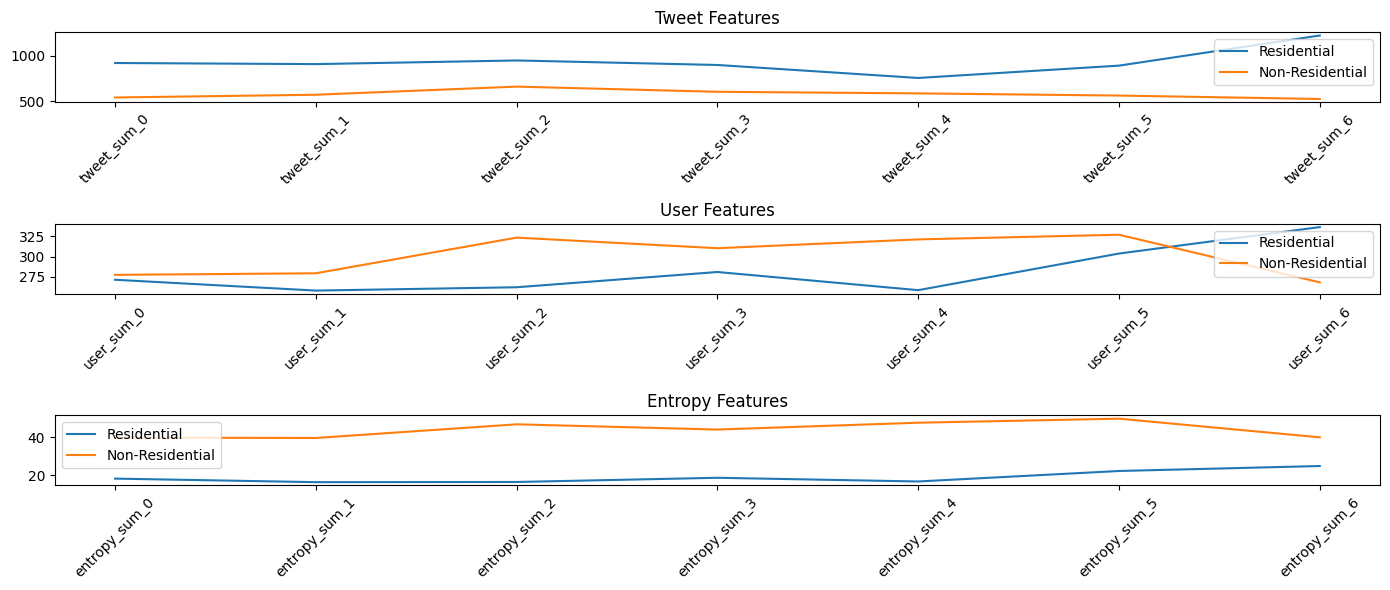

In [8]:
tweet_sums_daily = tweet_features.groupby(np.arange(len(tweet_features.columns)) // 24, axis=1).sum()
user_sums_daily = user_features.groupby(np.arange(len(user_features.columns)) // 24, axis=1).sum()
entropy_sums_daily = entropy_features.groupby(np.arange(len(entropy_features.columns)) // 24, axis=1).sum()

# Rename columns to reflect their new grouped nature
tweet_sums_daily.columns = [f'tweet_sum_{i}' for i in range(tweet_sums_daily.shape[1])]
user_sums_daily.columns = [f'user_sum_{i}' for i in range(user_sums_daily.shape[1])]
entropy_sums_daily.columns = [f'entropy_sum_{i}' for i in range(entropy_sums_daily.shape[1])]

labels = data['label']

# Group by the label to calculate the sum for R and NR areas
sum_tweets_daily_R = tweet_sums_daily[labels == 'R'].sum()
sum_tweets_daily_NR = tweet_sums_daily[labels == 'NR'].sum()
sum_users_daily_R = user_sums_daily[labels == 'R'].sum()
sum_users_daily_NR = user_sums_daily[labels == 'NR'].sum()
sum_entropy_daily_R = entropy_sums_daily[labels == 'R'].sum()
sum_entropy_daily_NR = entropy_sums_daily[labels == 'NR'].sum()

# Now create line plots for each category
plt.figure(figsize=(14, 6))
plt.subplot(3, 1, 1)
plt.plot(sum_tweets_daily_R.index, sum_tweets_daily_R.values, label='Residential')
plt.plot(sum_tweets_daily_NR.index, sum_tweets_daily_NR.values, label='Non-Residential')
plt.title('Tweet Features')
plt.legend()
plt.xticks(ticks=range(0, len(tweet_sums_daily.columns)), 
           labels=tweet_sums_daily.columns, 
           rotation=45)

plt.subplot(3, 1, 2)
plt.plot(sum_users_daily_R.index, sum_users_daily_R.values, label='Residential')
plt.plot(sum_users_daily_NR.index, sum_users_daily_NR.values, label='Non-Residential')
plt.title('User Features')
plt.legend()
plt.xticks(ticks=range(0, len(user_sums_daily.columns)), 
           labels=user_sums_daily.columns, 
           rotation=45)

plt.subplot(3, 1, 3)
plt.plot(sum_entropy_daily_R.index, sum_entropy_daily_R.values, label='Residential')
plt.plot(sum_entropy_daily_NR.index, sum_entropy_daily_NR.values, label='Non-Residential')
plt.title('Entropy Features')
plt.legend()
plt.xticks(ticks=range(0, len(entropy_sums_daily.columns)), 
           labels=entropy_sums_daily.columns, 
           rotation=45)
plt.tight_layout()
plt.show()


**Tweet Features:** Residential tweet volume appears consistently higher, with non-residential tweet volume trailing but following a similar pattern across the week.  
**User Features:** User counts in residential areas start lower but surpass non-residential counts mid-week, suggesting a possible increase in user activity in residential areas as the week progresses.   
**Entropy Features:** Entropy in non-residential areas is consistently higher across the week, implying a greater diversity of tweets, which remains relatively unchanged throughout the week.   
***Compare with hourly data***
This contrasts with daily data where you might see more variability day-to-day. Daily aggregation smooths out such fluctuations, potentially highlighting more stable, long-term patterns in user behavior and tweet characteristics.

### 3.1.2.3 Feature Aggregation and Visualization   
Aggregating user, tweet, and entropy features into sums and then visualizing the distributions of these aggregated features for different labels 

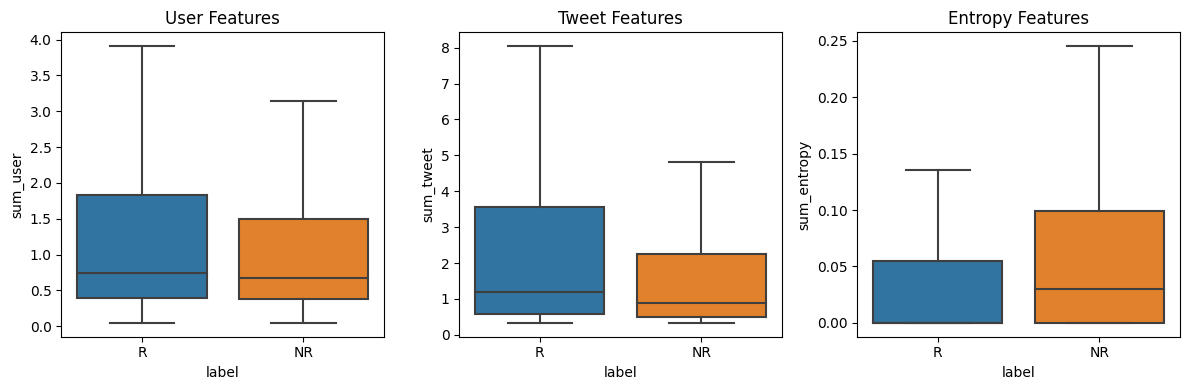

In [9]:
# Sum the 'user' features
data['sum_user'] = data.filter(regex='^user_').sum(axis=1)

# Sum the 'tweet' features
data['sum_tweet'] = data.filter(regex='^tw_').sum(axis=1)

# Sum the 'entropy' features
data['sum_entropy'] = data.filter(regex='^entropy_').sum(axis=1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.boxplot(x='label', y='sum_user', data=data, showfliers=False)
plt.title('User Features')
plt.subplot(1, 3, 2)
sns.boxplot(x='label', y='sum_tweet', data=data,  showfliers=False)
plt.title('Tweet Features')
plt.subplot(1, 3, 3)
sns.boxplot(x='label', y='sum_entropy', data=data,  showfliers=False)
plt.title('Entropy Features')
plt.tight_layout()


- Higher median user activity in residential areas.
- Greater tweet volume in residential areas, with wider variability.
- Slightly higher median tweet entropy in non-residential areas but more variation in residential areas.
- Overall, residential areas seem to exhibit more activity and variability in the data.

# ***3.2 Clustering***  
- Original data (2520, 504)
- PCA (90%) (2520, 31)
- Hourly data (2520, 21)
- Weekly data (2520, 3)


## **3.2.1 Exercise with k-means**

In [10]:
import os
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

from scipy.stats import mode
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import numpy as np
import random

*Original data for Kmeans clustering*

In [11]:
# Prepare the feature set for clustering, excluding non-numeric columns if necessary
original_data = data.drop(columns=['id', 'parcel_name', 'label', 'sum_user', 'sum_tweet', 'sum_entropy'])
print("check the original_data",original_data.shape)


check the original_data (2520, 504)


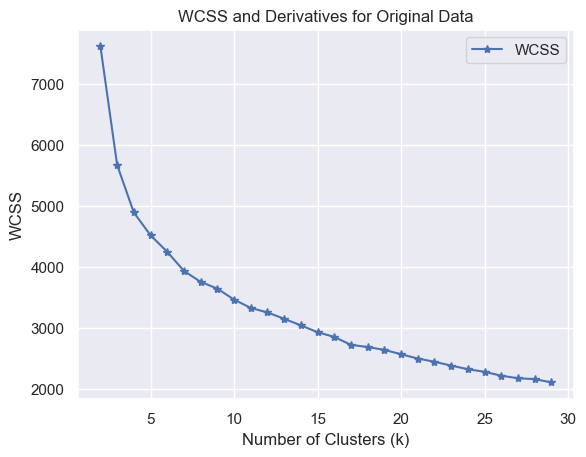

In [12]:
# List of k values
k_values = range(2, 30)

# List of withinss values
withinss_values = []

# Calculate withinss for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(original_data)
    withinss_values.append(kmeans.inertia_)

# Assume withinss_values are the previously calculated WCSS data
withinss_values = np.array(withinss_values)  # Make sure this is a NumPy array

# Plot the original data and the derivatives
plt.plot(k_values, withinss_values, '*-', label='WCSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('WCSS and Derivatives for Original Data')
plt.legend()
plt.show()



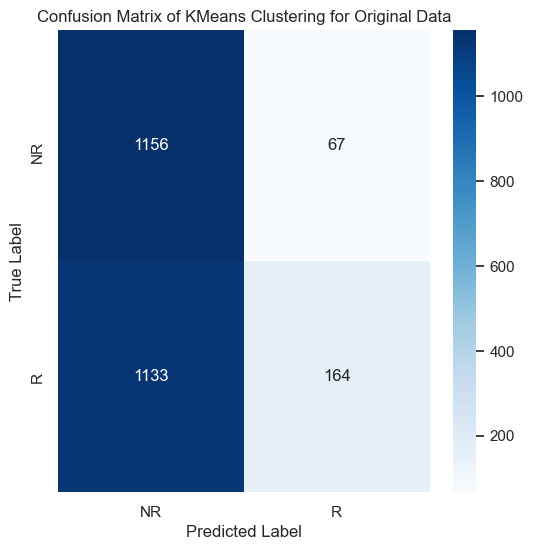

Classification Report:
               precision    recall  f1-score   support

          NR       0.51      0.95      0.66      1223
           R       0.71      0.13      0.21      1297

    accuracy                           0.52      2520
   macro avg       0.61      0.54      0.44      2520
weighted avg       0.61      0.52      0.43      2520



In [13]:
# Fit the KMeans model
best_original_k = 15
kmeans = KMeans(n_clusters=best_original_k, random_state=42)
kmeans.fit(original_data)

# Predict the cluster labels
predicted_labels = kmeans.predict(original_data)

# Map the predicted cluster labels to the true labels
label_mapping = {}
for cluster_id in set(predicted_labels):
    # Indices of rows in this cluster
    cluster_indices = predicted_labels == cluster_id
    # True labels of rows in this cluster
    real_labels = data.loc[cluster_indices, 'label']
    # Most common true label in this cluster
    most_common_label = mode(real_labels).mode[0]
    # Map cluster ID to the most common true label
    label_mapping[cluster_id] = most_common_label

# Apply the mapping
mapped_predicted_labels = pd.Series(predicted_labels).map(label_mapping)

# Compute the confusion matrix
conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KMeans Clustering for Original Data')
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)


## **3.2.2. Exercise with dimension reduction**

#### **3.2.2.1. PCA**
Apply PCA to reduce the dimensionality of the data while retaining 90% variances.   
*Original shape: (2520, 504), PCA shape: (2520, 31) The dimension decreased from 504 to 31*

Original shape: (2520, 504), PCA shape: (2520, 31)


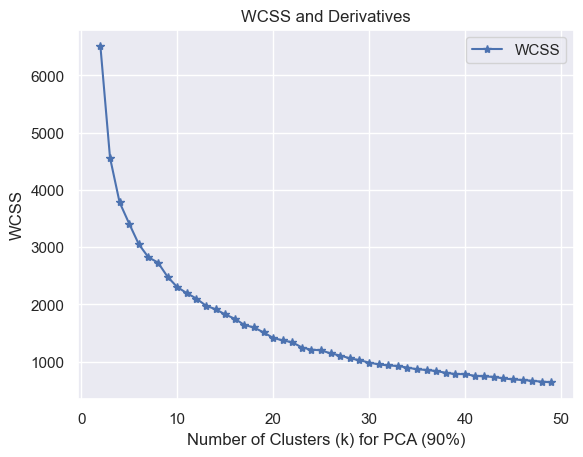

In [14]:
from sklearn.decomposition import PCA

# pca = PCA(n_components= round((original_data.shape[1])*0.9), random_state=42)
pca = PCA(n_components= 0.9, random_state=42)
X_pca = pca.fit_transform(original_data)
print(f"Original shape: {original_data.shape}, PCA shape: {X_pca.shape}")

# Check how many components PCA chose
num_components = pca.n_components_
# List of k values
k_values = range(2, 50)

# List of withinss values
withinss_values = []

# Calculate withinss for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k)

    kmeans.fit(X_pca)
    withinss_values.append(kmeans.inertia_)

# Assume withinss_values are the previously calculated WCSS data
withinss_values = np.array(withinss_values)  # Make sure this is a NumPy array

# Calculate the first derivative
first_derivative = np.diff(withinss_values) / np.diff(k_values)

# Calculate the second derivative
second_derivative = np.diff(first_derivative) / np.diff(k_values[:-1])  # Note that the length of k_values is reduced by one

# Plot the original data and the derivatives

plt.plot(k_values, withinss_values, '*-', label='WCSS')
plt.xlabel('Number of Clusters (k) for PCA (90%)')
plt.ylabel('WCSS')
plt.title('WCSS and Derivatives')
plt.legend()
plt.show()

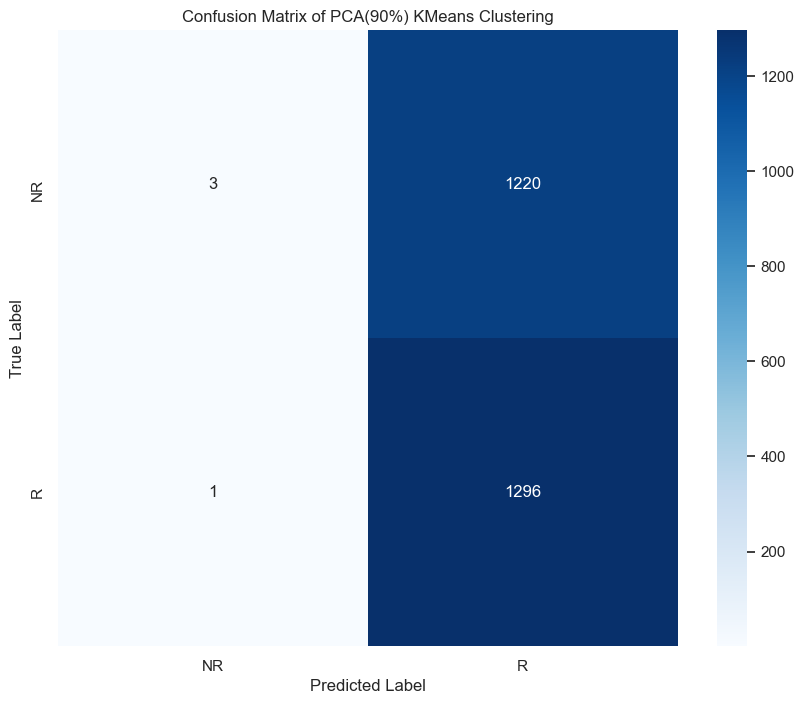

Classification Report:
               precision    recall  f1-score   support

          NR       0.75      0.00      0.00      1223
           R       0.52      1.00      0.68      1297

    accuracy                           0.52      2520
   macro avg       0.63      0.50      0.34      2520
weighted avg       0.63      0.52      0.35      2520



In [15]:
best_pca_k = 10
# Now, apply k-means clustering on the PCA-reduced data
kmeans_pca = KMeans(n_clusters= best_pca_k, random_state=42)
kmeans_pca.fit(X_pca)
predicted_labels_pca = kmeans_pca.predict(X_pca)

# Create the mapping from predicted cluster labels to actual labels
label_mapping_pca = {}
for cluster_id in np.unique(predicted_labels_pca):
    cluster_indices = (predicted_labels_pca == cluster_id)
    if cluster_indices.any():  # Ensure there's at least one point in the cluster
        real_labels = data.loc[cluster_indices, 'label']
        if not real_labels.empty:
            most_common_label = mode(real_labels).mode[0]
            label_mapping_pca[cluster_id] = most_common_label
        else:
            label_mapping_pca[cluster_id] = 'Unknown'
            print(f"No real labels in cluster {cluster_id}")

# Handle any unexpected cluster labels by defaulting to 'Unknown'
mapped_predicted_labels = [label_mapping_pca.get(label, 'Unknown') for label in predicted_labels_pca]

conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of PCA(90%) KMeans Clustering')
plt.show()

print("Classification Report:\n", class_report)

#####
**Before PCA**  
1. Precision for NR is higher (0.65), but with a very low recall (0.01), indicating that while most NR predictions were correct, the model failed to identify the majority of actual NR cases.
1. For R, the recall is very high (1.00), suggesting all R instances were identified, but precision is lower (0.52), which means there were many NR instances incorrectly labeled as R.
1. The f1-score for R is quite high (0.68) due to the perfect recall, but it's very low for NR (0.02) due to the extremely low recall.

**After PCA**  
1. Precision for NR dropped to 0.50, and recall increased significantly to 0.92, indicating that while the model identified most of the actual NR cases, there were also a lot of R instances misclassified as NR.
1. For R, the precision increased to 0.64, but recall dropped dramatically to 0.13, meaning the model was more precise when it did predict R but missed the majority of R cases.
1. The f1-score for NR improved to 0.65 due to better recall, but for R, it remained low at 0.22 because of the poor recall.   

***Overall***
- Both models struggle with accuracy, hovering around the 52% mark, which is not much better than flipping a coin in a balanced binary classification.
- The model after PCA performed better in identifying NR cases but at the cost of misclassifying many R cases.
- It appears that PCA, despite simplifying the dataset, has enabled the model to better capture the characteristics of the NR class, albeit with an increase in false positives for R.
- The low f1-score for R in both cases indicates that the models have a significant issue with misclassifying R instances, with the problem worsening after PCA.

#### **3.2.2.2 Decrease dimensions** [Daily/ Weekly Data]
A large number of features can make the model harder to interpret and understand.  
So in the nest step, I will decrease the dimensions manually by aggregating the features to daily and weekly data, and sum the data over the respective periods.

In [16]:
# Concatenate the DataFrames into one DataFrame with daily sums for tweets, users, and entropy.
daily_data = pd.concat([tweet_sums_daily, user_sums_daily, entropy_sums_daily], axis=1)
# Weekly sums for tweets, users, and entropy
weekly_data = data[['sum_user', 'sum_tweet', 'sum_entropy']]

##### *Daily*  

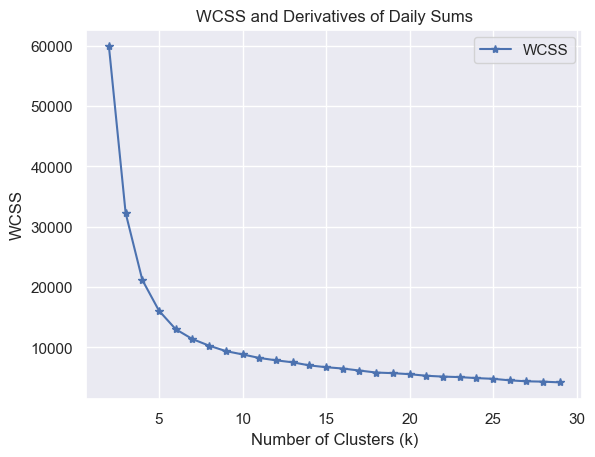

In [17]:
# List of k values
k_values = range(2, 30)

# List of withinss values
withinss_values = []

# Calculate withinss for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k)

    kmeans.fit(daily_data)
    withinss_values.append(kmeans.inertia_)

# Assume withinss_values are the previously calculated WCSS data
withinss_values = np.array(withinss_values)  # Make sure this is a NumPy array

# Calculate the first derivative
first_derivative = np.diff(withinss_values) / np.diff(k_values)

# Calculate the second derivative
second_derivative = np.diff(first_derivative) / np.diff(k_values[:-1])  # Note that the length of k_values is reduced by one

# Plot the original data and the derivatives
plt.plot(k_values, withinss_values, '*-', label='WCSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('WCSS and Derivatives of Daily Sums')
plt.legend()
plt.show()



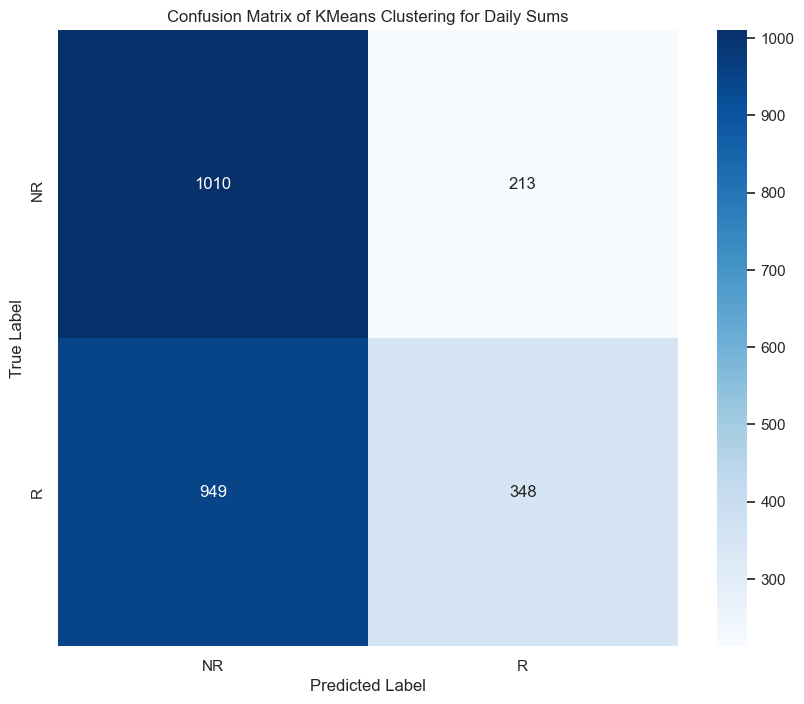

Classification Report:
               precision    recall  f1-score   support

          NR       0.52      0.83      0.63      1223
           R       0.62      0.27      0.37      1297

    accuracy                           0.54      2520
   macro avg       0.57      0.55      0.50      2520
weighted avg       0.57      0.54      0.50      2520



In [18]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(daily_data)

# Predict the cluster labels
predicted_labels = kmeans.predict(daily_data)

# Map the predicted cluster labels to the true labels
label_mapping = {}
for cluster_id in set(predicted_labels):
    # Indices of rows in this cluster
    cluster_indices = predicted_labels == cluster_id
    # True labels of rows in this cluster
    real_labels = data.loc[cluster_indices, 'label']
    # Most common true label in this cluster
    most_common_label = mode(real_labels).mode[0]
    # Map cluster ID to the most common true label
    label_mapping[cluster_id] = most_common_label

# Apply the mapping
mapped_predicted_labels = pd.Series(predicted_labels).map(label_mapping)

# Compute the confusion matrix
conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KMeans Clustering for Daily Sums')
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)


***Daily Sum Data:***

- Slightly better precision for NR (0.52) and recall for R (0.27) compared to before PCA, indicating an improved ability to correctly label NR and a small improvement in identifying R instances.
- The f1-score for NR is higher (0.63) than R's (0.38), suggesting the model is better at identifying NR instances.
- Overall accuracy (0.54) is marginally better than before or after PCA.

##### *Weekly*  
Only using the sum_user, sum_tweet, and sum_entropy


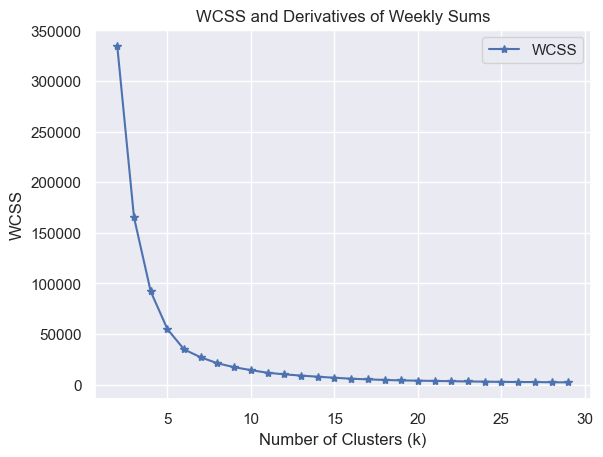

In [19]:
# List of k values
k_values = range(2, 30)

# List of withinss values
withinss_values = []
# Calculate withinss for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k)

    kmeans.fit(weekly_data)
    withinss_values.append(kmeans.inertia_)

# Assume withinss_values are the previously calculated WCSS data
withinss_values = np.array(withinss_values)  # Make sure this is a NumPy array

# Calculate the first derivative
first_derivative = np.diff(withinss_values) / np.diff(k_values)

# Calculate the second derivative
second_derivative = np.diff(first_derivative) / np.diff(k_values[:-1])  # Note that the length of k_values is reduced by one

# Plot the original data and the derivatives
plt.plot(k_values, withinss_values, '*-', label='WCSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('WCSS and Derivatives of Weekly Sums')
plt.legend()
plt.show()

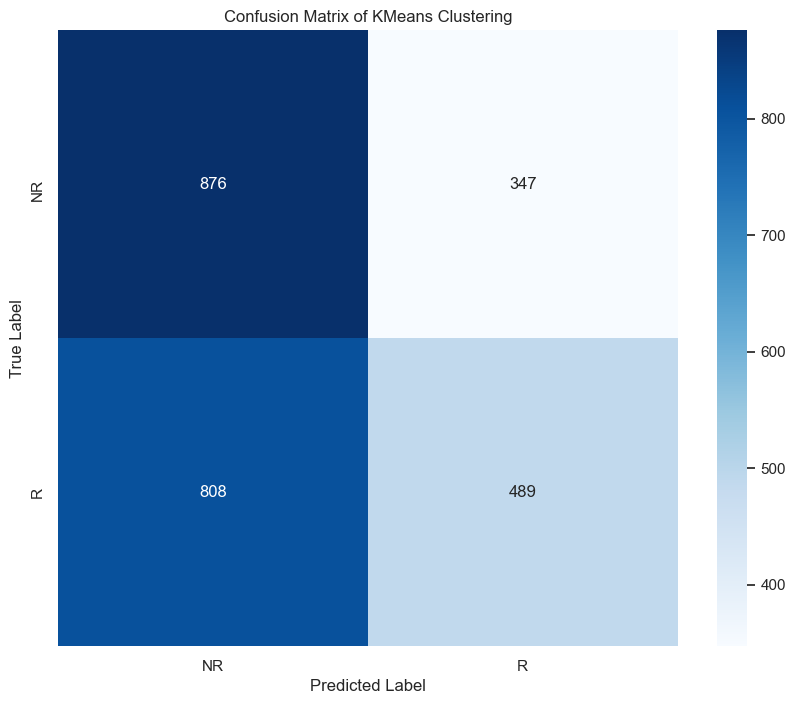

Classification Report:
               precision    recall  f1-score   support

          NR       0.52      0.72      0.60      1223
           R       0.58      0.38      0.46      1297

    accuracy                           0.54      2520
   macro avg       0.55      0.55      0.53      2520
weighted avg       0.55      0.54      0.53      2520



In [20]:
# Assuming we have the true labels in the 'label' column
true_labels = data['label']
# Create an instance of KMeans with k=10
kmeans = KMeans(n_clusters= 14)
# Fit the KMeans model to the standardized data
kmeans.fit(weekly_data)

# Predict the cluster labels for the data
predicted_labels = kmeans.predict(weekly_data)

# Map predicted cluster labels to true labels using the known labels in the dataset
label_mapping = {}
for cluster_id in set(predicted_labels):
    # Find the indices of rows in this cluster
    cluster_indices = (predicted_labels == cluster_id)
    # Get the true labels of those rows
    real_labels = data.loc[cluster_indices, 'label']
    # Find the most common true label in this cluster
    most_common_label = mode(real_labels).mode[0]
    # Map the cluster_id to the most common true label
    label_mapping[cluster_id] = most_common_label

# Now we have a mapping from cluster ID to the true label
# Apply this mapping to get the true labels for the entire dataset
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]
result = pd.Series(predicted_labels).map(label_mapping)
conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KMeans Clustering')
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)

***Weekly Sum Data:***

- Precision for NR is the same as in the daily sum (0.52), but recall is lower (0.72).
- Precision for R is lower (0.59) compared to the daily sum, and recall is higher (0.37).
- The f1-scores are slightly lower for both NR and R compared to the daily sum data, but overall accuracy is the same (0.54).
- The macro and weighted averages are slightly higher than the daily sum, indicating a marginally more balanced performance across classes.

### ***Summary***  
**Comparison with PCA Results:**

- Both daily and weekly sum data have higher recall rates for NR compared to before PCA, suggesting better identification of the NR class.
- Precision for R is higher in the daily and weekly sum data compared to after PCA, indicating fewer instances of R are mislabeled.
- The overall accuracy for both daily and weekly sums is higher than before PCA and equivalent to after PCA, indicating a more balanced and slightly better model performance.
- F1-scores for NR in daily and weekly data are close to after PCA, but for R, they are significantly better, suggesting improvements in how R instances are classified compared to the PCA models. 

***My Guess as to the Resaons for the Observed Trends!:***
- *The aggregation into daily and weekly sums may have helped to **emphasize patterns** in the data that are relevant for classification, potentially **reducing noise** that might be present on an hourly scale.*  
- *The use of sums rather than raw hourly data could highlight trends and behaviors more clearly, improving the distinction between NR and R.*

## **3.2.3. Comparison of K-means and Agglomerative Hierarchical Clustering**

In [21]:
from sklearn.cluster import AgglomerativeClustering

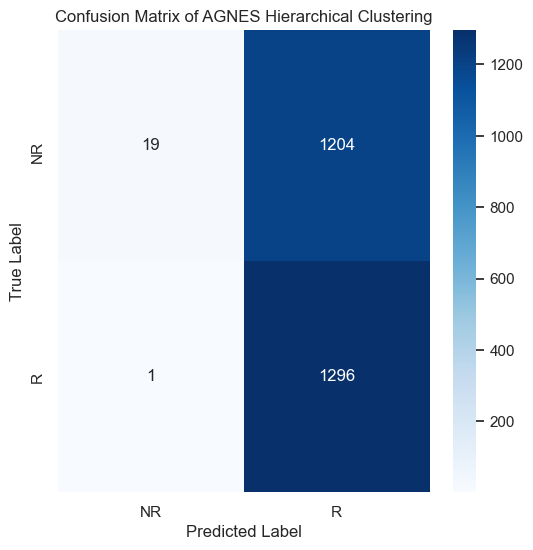

Classification Report:
               precision    recall  f1-score   support

          NR       0.95      0.02      0.03      1223
           R       0.52      1.00      0.68      1297

    accuracy                           0.52      2520
   macro avg       0.73      0.51      0.36      2520
weighted avg       0.73      0.52      0.37      2520



In [22]:
# Apply the AGNES hierarchical clustering algorithm
agg_clustering = AgglomerativeClustering(
    n_clusters = best_original_k,  # This should be set to the best k value found in Section 3.2.1
    affinity='euclidean',
    linkage='ward'  # Try 'ward', 'complete', 'average', 'single', etc.
)
predicted_labels = agg_clustering.fit_predict(original_data)

# Map the predicted cluster labels to the true labels
label_mapping = {}
for cluster_id in range(best_original_k):
    # Find the indices of points in this cluster
    indices = (predicted_labels == cluster_id)
    # Get the actual labels of these points
    actual_labels = true_labels[indices]
    # Determine the most common label
    most_common_label = mode(actual_labels).mode[0]
    label_mapping[cluster_id] = most_common_label

# Apply the mapping
mapped_predicted_labels = pd.Series(predicted_labels).map(label_mapping)

# Compute the confusion matrix
conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of AGNES Hierarchical Clustering')
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)


# ***3.3 Classification***

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

*Use the raw feature set and reserve 20% of all records as the test set and use the rest as 
the training set.*

In [24]:
# Split data into features and target
X = original_data  # This assumes 'label' is the name of your target column
y = data['label']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## **3.3.1. Create Model**

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [26]:
# Scale the data
scaler = StandardScaler()
X_train_nomalized = normalize(X_train)
X_test_nomalized = normalize(X_test)

### **3.3.1.1. KNN**

              precision    recall  f1-score   support

          NR       0.61      0.66      0.64       245
           R       0.65      0.61      0.63       259

    accuracy                           0.63       504
   macro avg       0.63      0.63      0.63       504
weighted avg       0.63      0.63      0.63       504



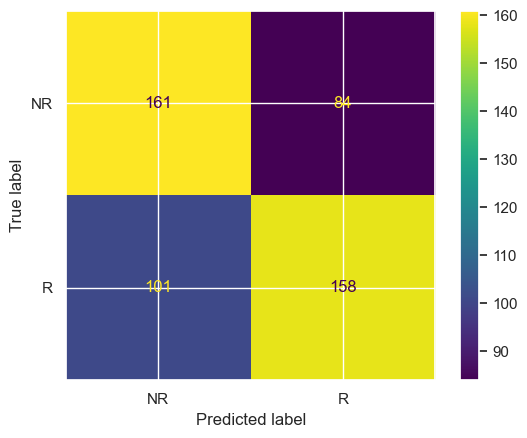

In [27]:
# Set up the KNN classifier
knn_cls = KNeighborsClassifier(n_neighbors=5)
knn_cls.fit(X_train_nomalized, y_train)
knn_cls.score(X_test_nomalized, y_test)
# make prediction given new unlabeled data (test set)
y_pred_knn = knn_cls.predict(X_test_nomalized)
cm = confusion_matrix(y_test, y_pred_knn, labels=knn_cls.classes_)
# visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_cls.classes_)
disp.plot()
print(classification_report(y_test, y_pred_knn, target_names=np.unique(y_test)))

### **3.3.1.2. Decision Tree**

              precision    recall  f1-score   support

          NR       0.58      0.67      0.62       245
           R       0.63      0.54      0.58       259

    accuracy                           0.60       504
   macro avg       0.60      0.60      0.60       504
weighted avg       0.61      0.60      0.60       504



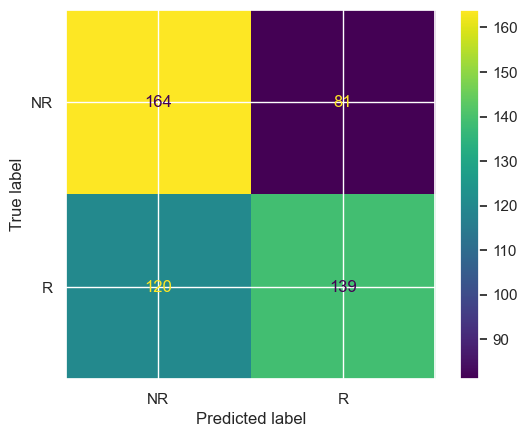

In [28]:
dt_cls = DecisionTreeClassifier(criterion='gini')
dt_cls.fit(X_train_nomalized, y_train)

# Evaluate the classifier on the test set
y_pred_dt = dt_cls.predict(X_test)

# Compute and visualize the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=dt_cls.classes_)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt_cls.classes_)
disp_dt.plot()
# Print the classification report
print(classification_report(y_test, y_pred_dt, target_names=np.unique(y_test)))


### **3.3.1.3. Random Forest**

Best parameters for Random Forest: {'n_estimators': 100}
              precision    recall  f1-score   support

          NR       0.75      0.68      0.71       245
           R       0.72      0.78      0.75       259

    accuracy                           0.73       504
   macro avg       0.73      0.73      0.73       504
weighted avg       0.73      0.73      0.73       504



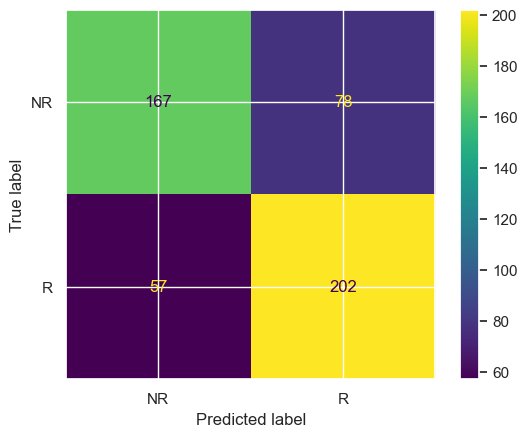

In [29]:
# Define a range of hyperparameters to test
# This example will vary the 'n_estimators', 'max_depth' and 'min_samples_split'
param_grid_rf = {
    'n_estimators': [10, 50, 100, 150, 200]}

# Set up the Random Forest classifier
rf = RandomForestClassifier()

# Set up GridSearchCV to test the parameter grid using cross-validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=10, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

# Find the best combination of parameters
best_params_rf = grid_search_rf.best_params_
print(f"Best parameters for Random Forest: {best_params_rf}")

# Initialize the Random Forest classifier with the best parameters
rf_cls = RandomForestClassifier(**best_params_rf)
rf_cls.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred_rf = rf_cls.predict(X_test)

# Compute and visualize the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_cls.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_cls.classes_)
disp_rf.plot()

# Print the classification report
print(classification_report(y_test, y_pred_rf, target_names=np.unique(y_test)))


### **3.3.1.4. ANN**

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

              precision    recall  f1-score   support

          NR       0.65      0.64      0.65       245
           R       0.67      0.67      0.67       259

    accuracy                           0.66       504
   macro avg       0.66      0.66      0.66       504
weighted avg       0.66      0.66      0.66       504



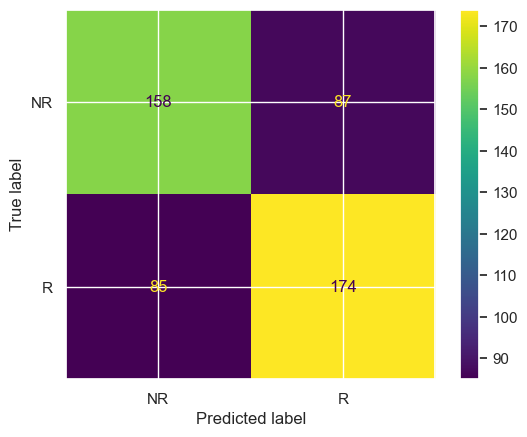

In [31]:
# Original labels 'R' and 'NR' which need to be encoded numerically
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

mlp_classifier = MLPClassifier(hidden_layer_sizes=(200,50),  # 50 hidden layer with 200 neurons
                               activation='relu',          # ReLU activation function
                               solver='sgd',              # The solver for weight optimization.
                               max_iter=500,               # Maximum number of iterations.
                               random_state=42,            # Random state for reproducibility
                               learning_rate_init=0.001,  # Initial learning rate
                               batch_size=10)   

# Train the model
mlp_classifier.fit(X_train, y_train_encoded)

# Predict labels
y_pred_ann = mlp_classifier.predict(X_test)
y_pred_ann_label = label_encoder.inverse_transform(y_pred_ann)
# Compute and visualize the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_ann_label, labels=rf_cls.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_cls.classes_)
disp_rf.plot()

# Print the classification report
print(classification_report(y_test, y_pred_ann_label, target_names=np.unique(y_test)))

## **3.3.2. K-Fold Cross-validation**

In [1]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=2)


### **ANN K-Fold cross validation**

In [33]:
results_ann=cross_val_score(mlp_classifier, X_train, y_train_encoded, cv=kfold)

In [ ]:
mean_score = results_ann.mean()
std_deviation_score = results_ann.std()

print(f"Average score across all 10 folds: {mean_score:.2f}")
print(f"Standard deviation of the scores: {std_deviation_score:.2f}")



NameError: name 'results_ann' is not defined